## Puddle Python Client Demo ##

This notebook demonstrates how to use the Puddle Python client. It covers the following topics:

- How to obtain and install the Puddle Python Client.
- How to create a new system.
- How to connect to a Driverless AI running on provisioned system.
- How to stop the system.
- How to terminate the system.

### Prerequisites ###
This notebook was created using **Python 3.6**. Other versions *may* work with Puddle, but Driverless AI requires Python 3.6. 

To download the **Puddle Python Client**, go to the Puddle Web UI and select `Download Python Client` from the user's menu in the top right-hand corner. This downloads the Puddle wheel.
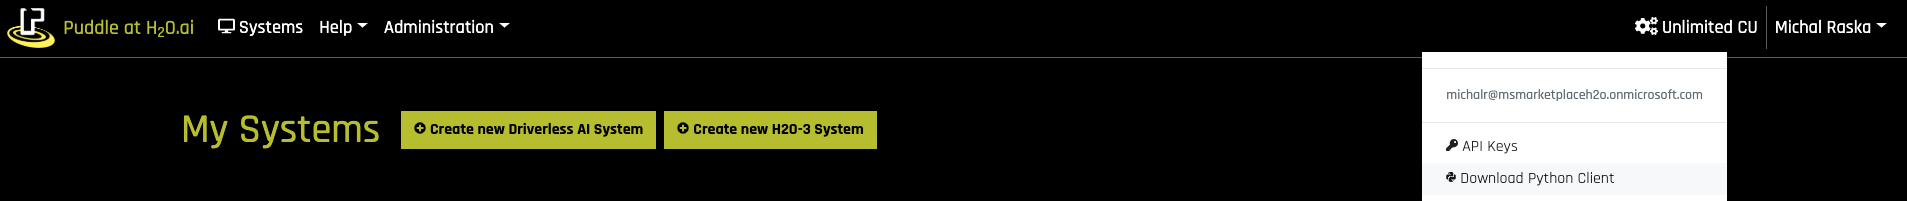

This wheel can be installed using:
```
pip install puddle_client-*-py3-none-any.whl
```


**API keys** can be obtained from Puddle Web UI. Select the `API Keys` from the user's menu in the top right-hand corner.
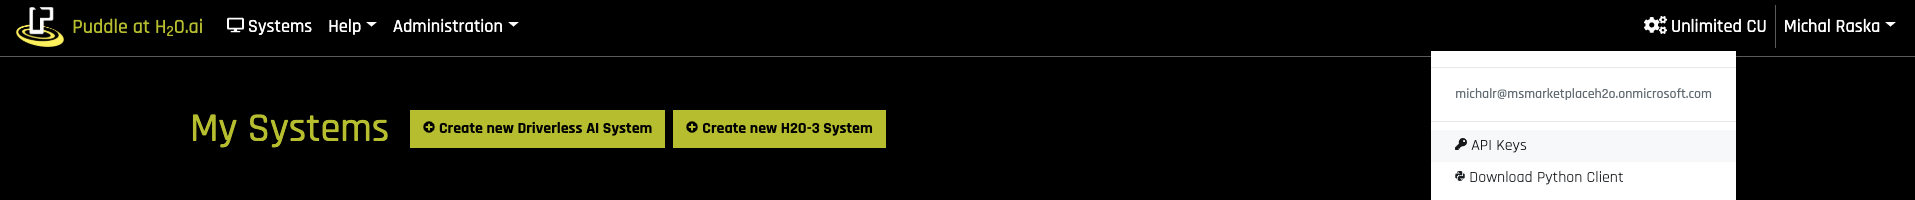

The last requirement is the **Driverless AI Python Client**. The Driverless AI Python Client is not required in the beginning of this demo, but it is needed in order to create experiments. To download the Driverless AI Python Client, a running instance of Driverless AI is required. If no such instance is available, wait until Puddle provisions a new system. This system can then be used to download the client. Once Driverless AI is available, access the UI of Driverless AI and then on the top menu, select the RESOURCES > PYTHON CLIENT link. This downloads the h2oai_client wheel. **Please make sure that you are using the correct combination of Driverless AI Python Client version and Driverless AI version.**

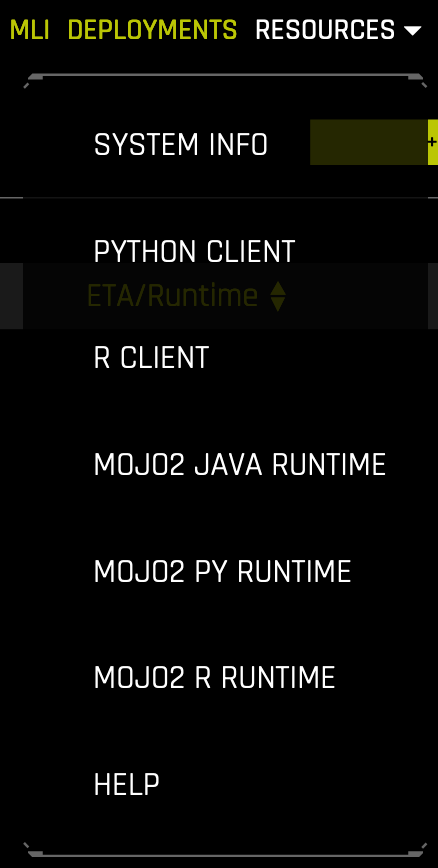

This wheel can be installed using:
```
pip install h2oai_client-*-py3-none-any.whl
```

### Creating a new system ###

At first we need to import some **Puddle** modules.

In [ ]:
import os
import time

from puddle.client import *

Let's check that all of the required environment variables are set. Puddle needs the following environment variables:

- `PUDDLE_server_address` - URL where Puddle is accessible.
- `PUDDLE_api_key_id` - API Key ID which can be obtained if you go to the Puddle UI, then you should click the user menu in top right corner and then you should select the `API Keys` option. 
- `PUDDLE_api_secret_key` - API Secret Key which can be obtained if you go to the Puddle UI, then you should click the user menu in top right corner and then you should select the `API Keys` option.

If you are missing any of these, please do `export <VARIABLE>=<VALUE>` and reload the environment if required.

In [ ]:
print("PUDDLE_server_address =", os.getenv("PUDDLE_server_address", None))
print("PUDDLE_api_key_id =", os.getenv("PUDDLE_api_key_id", None))
print("PUDDLE_api_secret_key =",os.getenv("PUDDLE_api_secret_key", None))

Now an instance of `SystemsClient` should be created. In this example we'll be using **Amazon AWS**. If you want to use **Microsoft Azure** instead, then please replace `CLOUD_AWS` with `CLOUD_AZURE`. If you want to use **Google GCP** instead, then please replace `CLOUD_AWS` with `CLOUD_GCP`. `SystemsClient` will automatically read the environment variables (which were discussed earlier) to obtain backend URL and credentials. Backend address can be overriden by setting the `server_address` parameter in the constructor.

In [ ]:
systems_client = SystemsClient(cloud=CLOUD_AWS)

The created instance of `SystemsClient` is now ready to use. Let's proceed by creating a new system.

This demo shows the easiest way that a new system can be created. There are also other parameters. If you want to explore them, please review the documentation.

The following cell will create a system named `python-client-demo` with `Driverless AI 1.7.0` backed by the `CPU Small` instance type. Your Puddle instance might not have `CPU Small` or `Driverless AI 1.7.0`. Please adjust these variables to fit your Puddle instance. In this example, we are also setting the tag `dept` (department). We are using value `eng` (engineering) for this tag. Again, if your Puddle does not have this tag, please adjust the list accordingly, or omit it completly.

In [ ]:
system = systems_client.create(
    name="python-client-demo",
    product=PRODUCT_DAI,
    version="1.7.0",
    instance_type_name="CPU Small",
    tags=[TagData("dept", "eng")],
)
print(system)

We need to wait for the system to be ready. This could take up to 15 minutes, but it's usually completed sooner.

In [ ]:
systems_client.wait_for_system_started(system.id)

Let's observe the system once again. It should be up and running now.

In [ ]:
system = systems_client.get(system.id)
print(system)

### Running an Experiment ###

Now we need to import some **Driverless AI** modules. Then we will be able to load a dataset and run an experiment. Please make sure that the **correct version of Driverless AI Client is installed**. If not please refer to Prerequisites section of this demo.

In [ ]:
from h2oai_client import Client

Let's connect to Driverless AI. We'll use `system` from Puddle to provide address and credentials.

In [ ]:
h2oai = Client(address=system.default_url, username=system.username, password=system.password)

For purpose of this demo, we will be using the IRIS dataset.

In [ ]:
train = h2oai.create_dataset_from_s3_sync("https://s3.amazonaws.com/h2o-public-test-data/smalldata/extdata/iris_wheader.csv")

Everything is ready now, and we can start an experiment.

In [ ]:
experiment = h2oai.start_experiment_sync(dataset_key=train.key,
                                         target_col="class",
                                         is_classification=True,
                                         accuracy=1,
                                         time=1,
                                         interpretability=1,
                                         scorer="AUC",
                                         enable_gpus=False,
                                         seed=1234)

### Stopping the System ###

Once the experiment is finished, we should deallocate (stop) the system. This **does not** destroy anything. The system can be restarted again and all data will be there.


In [ ]:
systems_client.stop(system.id)
systems_client.wait_for_system_stopped(system.id)
system = systems_client.get(system.id)
print(system)

For purpose of this demo we don't need to restart the system, but if you need to restart it, you can use the following snippet:

```python
systems_client.start(system.id)
systems_client.wait_for_system_started(system.id)
system = systems_client.get(system.id)
print(system)
```

### Terminating the System ###

For purpose of this demo we don't need to do anything else with this system, so we can terminate it. This operation **cannot be reverted**. Everything is gone forever, unless you saved it elsewhere.

In [ ]:
systems_client.terminate(system.id)
systems_client.wait_for_system_terminated(system.id)
system = systems_client.get(system.id)
print(system)